In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from langdetect import detect

In [3]:
df = pd.read_csv('merged.csv' , sep='\t', encoding='utf-8', index_col=0)
df

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
0,unsexed green tree python + 60cm vivtek,1000.0,Python Snake,3 years,Mixed,~3years old gtp biak x sorong Typical gtp a...,Patryk M.,Aberdeen,Individual,sale,reptiles
1,Leopard gecko (f),80.0,Gecko,1 year,Female,Selling this leopard gecko I've had the joy of...,Dana I.,Aberdeen,Individual,sale,reptiles
2,rexy,100.0,Iguana,4 years,Male,rexy needs a new home ASP sadly I don't not ...,Gillian W.,Aberdeen,Individual,sale,reptiles
3,Panther Chameleon and full set up,550.0,Chameleon,9 months,Male,Blue is a 6 month old Nosey Mitsio chameleon. ...,Craig H.,Aberdeen,Individual,sale,reptiles
4,Hand reared white Indian ringnecks,300.0,Parakeets,9 weeks,Mixed,I have 2 stunning white Indian ringnecks. 1 ma...,Dave T.,Aberdeen,Individual,sale,birds
...,...,...,...,...,...,...,...,...,...,...,...
48776,canarys for sale all colour plus new colours,40.0,Canaries,7 weeks,Mixed,there are all mixed cocks and hens new volour ...,Robert n.,Knottingley,Breeder,sale,birds
48777,TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW,2150.0,Macaws,4 years,Male,Rainbow is a beautiful example of a blue and g...,The Bradford Birdman,Bradford,Licensed Breeder,sale,birds
48778,Hand reared indian ringnecks babys,350.0,Parrots,1 year,Male,Hand reared cuddly silly tame little babys for...,Waqar A.,Bradford,Breeder,sale,birds
48779,One yellow one orange canary.,60.0,Canaries,2 years,Mixed,I’m reluctantly listing my canaries (peach and...,Amylia R.,Barnsley,Individual,sale,birds


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48781 entries, 0 to 48780
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            48781 non-null  object 
 1   price            48781 non-null  float64
 2   species          48781 non-null  object 
 3   age              48781 non-null  object 
 4   gender           48781 non-null  object 
 5   description      48781 non-null  object 
 6   seller_name      48781 non-null  object 
 7   seller_location  48781 non-null  object 
 8   seller_type      48781 non-null  object 
 9   listing_type     48781 non-null  object 
 10  pet_type         48781 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.5+ MB


In [16]:
df.nunique()

Title              37519
price                394
species              438
age                   89
gender                 7
description        44796
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [6]:
df['gender'].value_counts()

unknown                11934
Mixed                   6199
Male                    3719
1 male                  2857
Female                  2796
                       ...  
03 male / 03 female        1
03 male / 01 female        1
03 male / 02 female        1
7 male / 8 female          1
05 male / 1 female         1
Name: gender, Length: 139, dtype: int64

We should combine these 'x number of male and y number of female' as mixed litters and remove the numbers from the others

In [7]:
df['gender'] = df['gender'].apply(lambda x: 'Mixed' if (' male' in x and 'female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Female' if (' female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Male' if (' male' in x) else x)
df['gender'].value_counts()

Mixed       20614
unknown     11934
Male         8850
Female       7085
Mare          139
Gelding       117
Stallion       42
Name: gender, dtype: int64

This is satisfactory enough. Mare, Gelding and Stallion are horses.

In [8]:
df.nunique()

Title              37519
price                394
species              438
age                  101
gender                 7
description        44796
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [9]:
df['seller_type'].value_counts()

Individual          29107
Breeder             16573
Licensed Breeder     2388
Rescue/Charity        707
Company                 6
Name: seller_type, dtype: int64

In [10]:
df['seller_location'].value_counts().tail(100)

Appleby In Westmorland    1
Гул                       1
Солфорд                   1
St Austell                1
Busveal                   1
                         ..
Wylam                     1
Chester Le Street         1
Filey                     1
Ulceby                    1
Ilkley                    1
Name: seller_location, Length: 100, dtype: int64

Funny to have location data in foreign language. Probably should take a look at the posting.

In [11]:
df.loc[df['seller_location'] == 'Солфорд']

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
41535,sold,900.0,Siamese,4 months,Mixed,We have available 1 Blue Point Siamese boy and...,Viktorija K.,Солфорд,Breeder,sale,cats


In [12]:
df['age'].value_counts().tail(20)

2001              3
16 years          3
2000              3
Due in 6 weeks    3
2003 years        2
Due in 6 days     2
18 years          2
2004 years        2
20 years          2
2002 years        2
1998              1
2000 years        1
24 years          1
Due in 7 weeks    1
42 years          1
1999              1
66 years          1
2019 years        1
23 years          1
17 years          1
Name: age, dtype: int64

Some of these are very funny. probably it's the year of birth. Longer living animals tends to have their year of birth recorded as age, horses in particular

In [15]:
df['age'] = df['age'].apply(lambda x: 0 if ('Due' in x) else x)
df['age'].value_counts().tail(20)

2021 years    3
unknown       3
2001          3
16 years      3
2000          3
2003          3
2004 years    2
2003 years    2
18 years      2
20 years      2
2002 years    2
1999          1
2000 years    1
24 years      1
1998          1
42 years      1
66 years      1
2019 years    1
23 years      1
17 years      1
Name: age, dtype: int64

In [152]:
df['pet_type'].value_counts()

dogs             23151
cats             11489
rabbits           4400
rodents           2321
birds             2068
reptiles          1955
poultry           1528
fish              1031
invertebrates      366
horses             298
livestock          174
Name: pet_type, dtype: int64

In [153]:
df['price'].value_counts()

1000.0    2139
200.0     1955
500.0     1737
1500.0    1736
150.0     1722
          ... 
27.0         1
785.0        1
1245.0       1
2499.0       1
1880.0       1
Name: price, Length: 394, dtype: int64

In [154]:
df.sort_values(by=['price'], ascending=False).head(20)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
24577,For TEMPORARY Foster/Temporary Adoption,11111111.0,British Shorthair,3 years,Male,I'm looking for a loving TEMPORARY foster home...,Amy W.,Newark,Individual,adoption,cats
1530,Working Cocker spaniel dog pup,9999999.0,Cocker Spaniel,12 weeks,Male,One Liver Working cocker spaniel dog pup for s...,Joanne b.,Lymington,Licensed Breeder,sale,dogs
9625,2 male Chihuahua puppies for sale,9999999.0,Chihuahua,9 weeks,Male,Here we have two beautiful stunning chihuahua ...,Danielle E.,Kidderminster,Individual,sale,dogs
42999,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗 SIRE is KC - slo...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
28646,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗 SIRE is KC - s...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
200,Franco,1234567.0,Golden Retriever,3 years,unknown,Lovely natured golden retriever. Great with c...,Colin M.,Inverurie,Breeder,stud,dogs
1144,Top Basset for Stud,1111111.0,Basset Hound,1 year,unknown,Looking to stud out my big boy probably only ...,Darren P.,Romsey,Individual,stud,dogs
17105,❌••L4 FLUFFY CARRIERS••❌Coco girl❌,987654.0,French Bulldog,14 weeks,Mixed,❤️Beautiful pups from our blue girl❤️ Romeo ...,JACQUELINE I.,Hailsham,Individual,sale,dogs
2821,Stolen coco,888888.0,Bengal,2 years,unknown,Good morning we haven't seen coco since 15th F...,Nic I.,Stonehouse,Individual,sale,cats
23757,ragdoll cross,150350.0,Ragdoll,10 weeks,Mixed,"5 stunning ragdoll cross kittens, 3 girls 2 bo...",Layna L.,Runcorn,Breeder,sale,cats


some of the pricing makes no sense, owner probably want potential buyer to contact them. We should drop these. these outliers make price histogram unworkable.

In [155]:
df.loc[df['price'] == 0.0]

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
32,African Cichlids bundle,0.0,Cichlids,1 year,unknown,"hi, I have got around 19 African cichlids look...",Margaret B,Peterculter,Breeder,sale,fish
33,Guppies for sale,0.0,Other/Mixed Breed,12 weeks,unknown,2 1/2 months old mixed guppies for sale: make...,Anil G.,Aberdeen,Individual,sale,fish
234,2 Beautiful Mini Lops,0.0,Mini Lop,1 year,Mixed,We are looking to rehome our 2 gorgeous bunnie...,Abigail W.,Helston,Individual,adoption,rabbits
296,HORSFIELD TORTOISES - 2 years old.,0.0,Tortoise,2 years,Female,Adoption only! Poppy & Penny are two beautifu...,Caley A.,Truro,Individual,adoption,reptiles
441,Full list baby ball python CB21,0.0,Python Snake,1 year,Mixed,"Passione breeder based in Southampton, here to...",Eden Garden Reptiles,Southampton,Breeder,sale,reptiles
...,...,...,...,...,...,...,...,...,...,...,...
46726,chocolate seal point female mini lop,0.0,Mini Lop,1 year,Female,daisy ❤️ chocolate seal point pure bred mini l...,Hip Hop B,Leeds,Breeder,sale,rabbits
46846,BABY BLUE HOLICER RABBITS,0.0,Mixed Breed,6 months,Male,Iv had to put these babies under mixed breed a...,Mini F Stud,Leeds,Breeder,sale,rabbits
46885,RARE BABY HOLICER BABIES - READ DESCRIPTION,0.0,Continental Giant,14 weeks,Mixed,- I have put them into the continental giant c...,Mini F Stud,Leeds,Breeder,sale,rabbits
46888,Rabbits for sale,0.0,English Lop,15 weeks,Mixed,"We have 5 beautiful rabbits for sale,they are ...",Kian R.,Wakefield,Individual,sale,rabbits


In [182]:
def price_plot_hist (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xlabel(entry)
        plt.xticks(rotation=90)
        sns.distplot(x = data.loc[data[column] == entry].price)
        plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


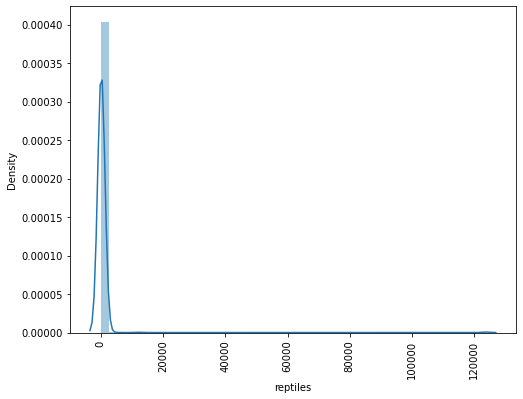

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


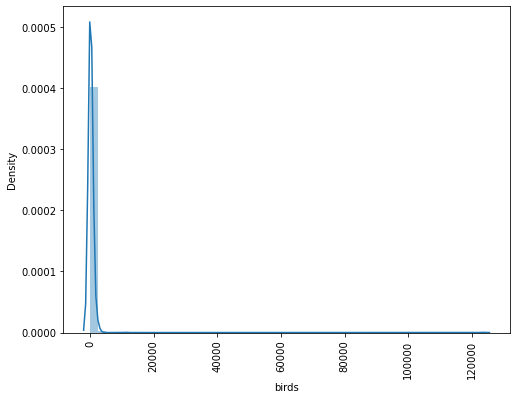

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


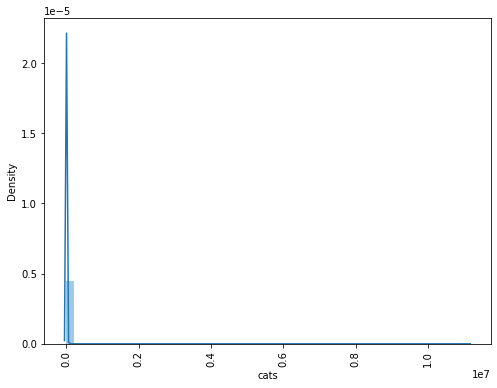

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


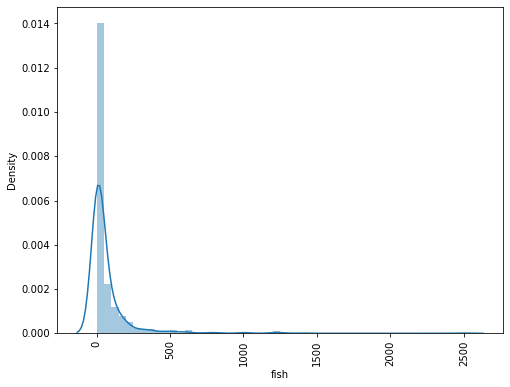

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


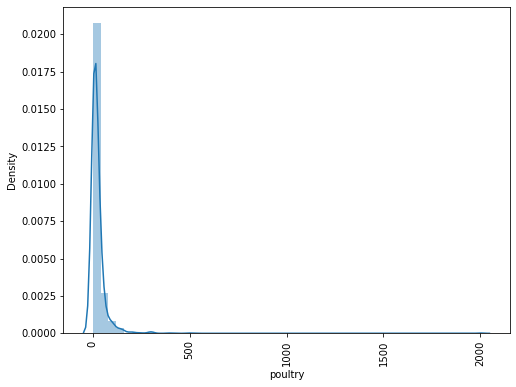

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


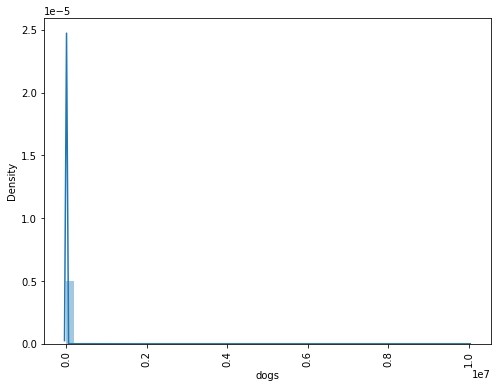

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


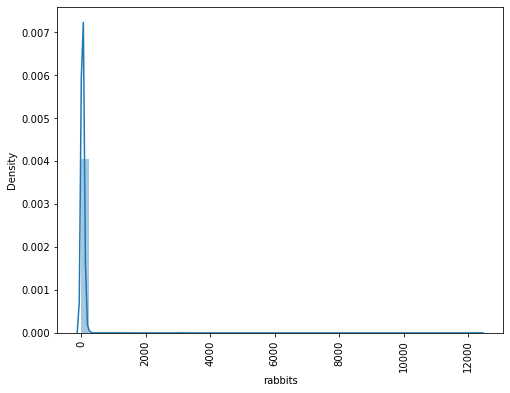

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


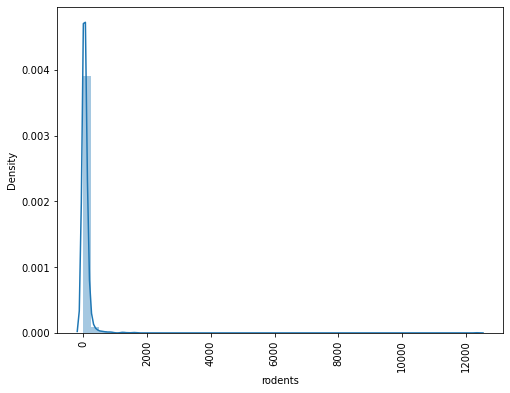

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


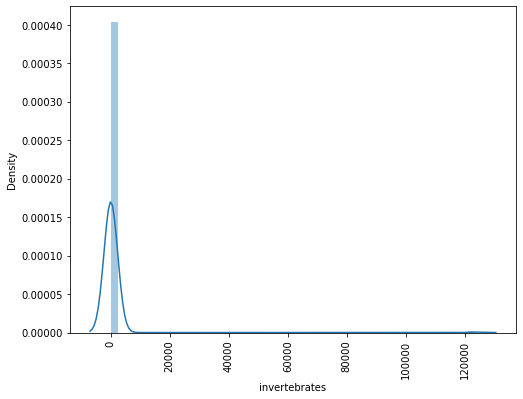

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


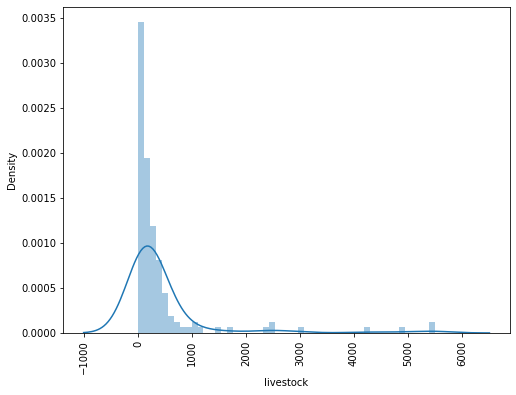

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


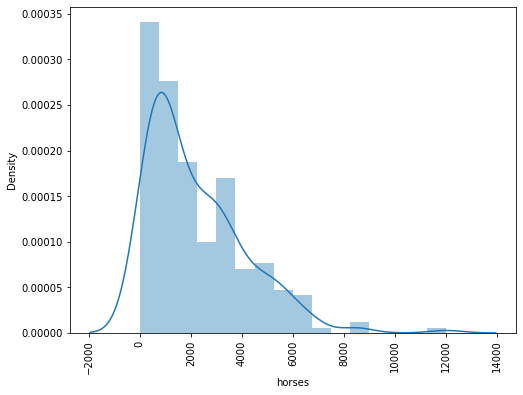

In [183]:
price_plot_hist (df,'pet_type')

In [185]:
def price_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].price).set_title(entry)
        plt.show()

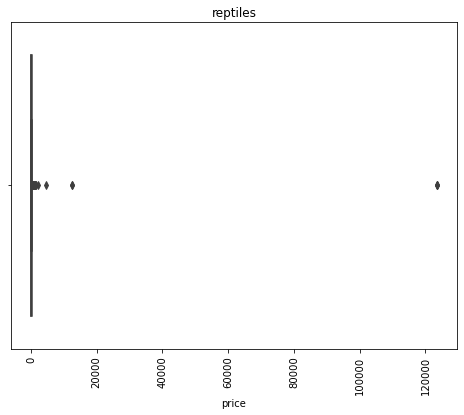

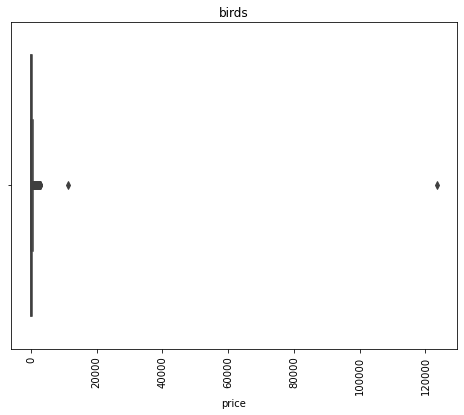

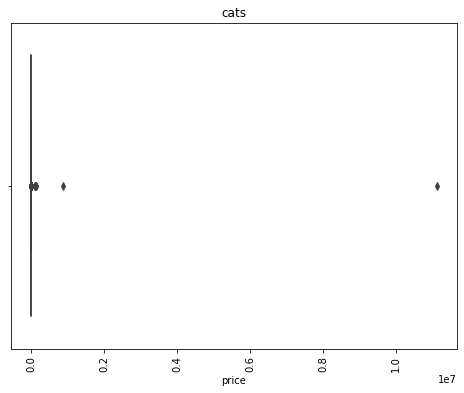

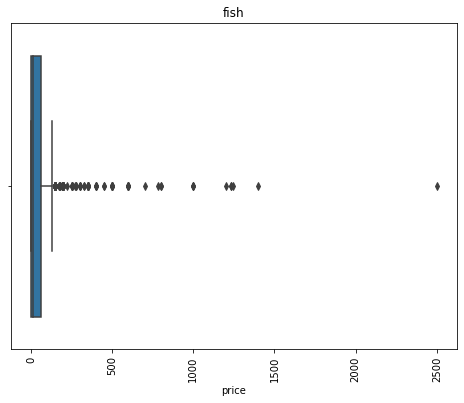

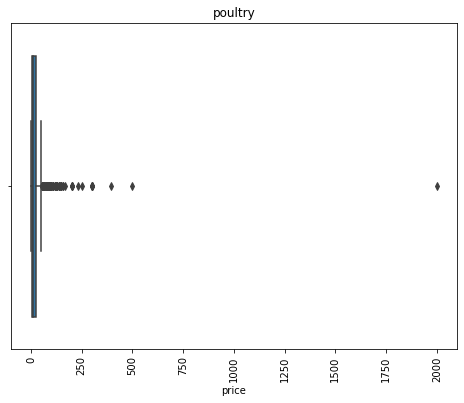

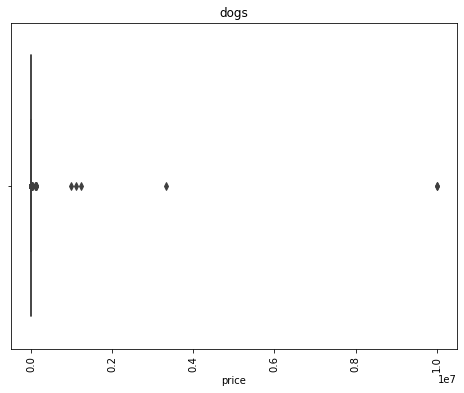

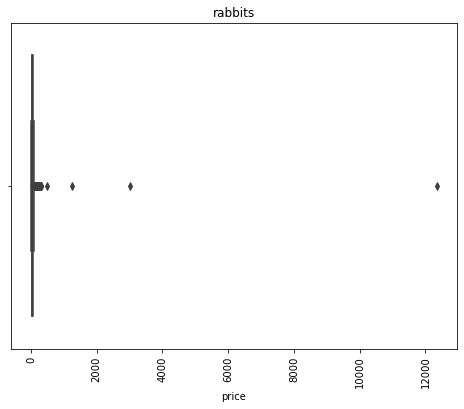

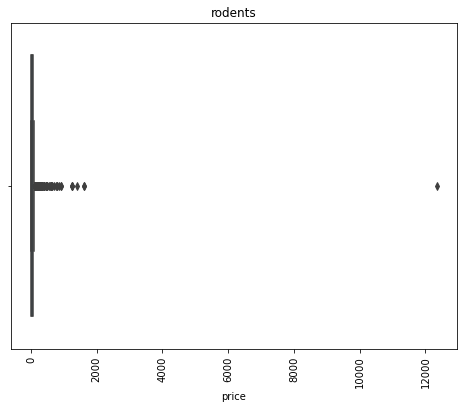

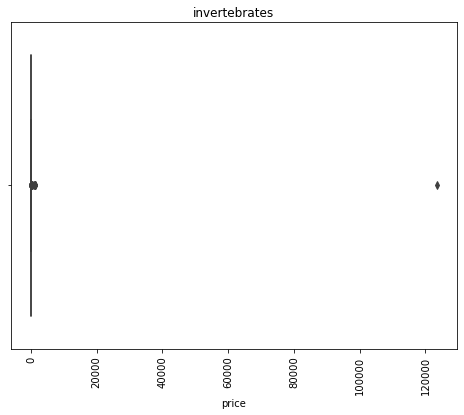

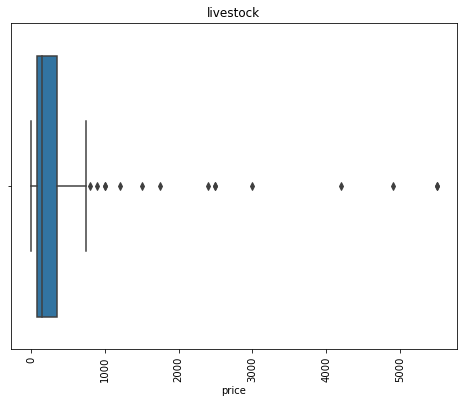

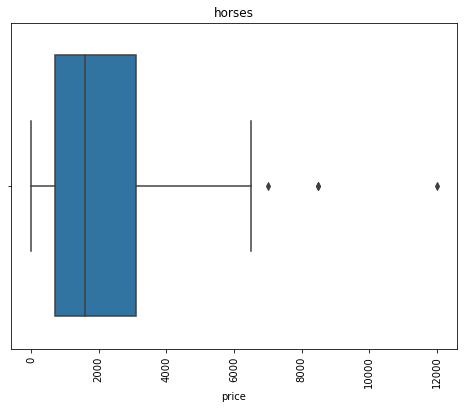

In [186]:
price_plot_box (df,'pet_type')

<AxesSubplot:ylabel='Density'>

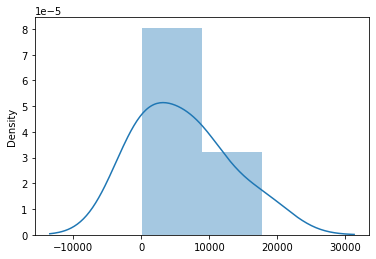

In [190]:
sns.distplot(x = df['gender'].value_counts())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


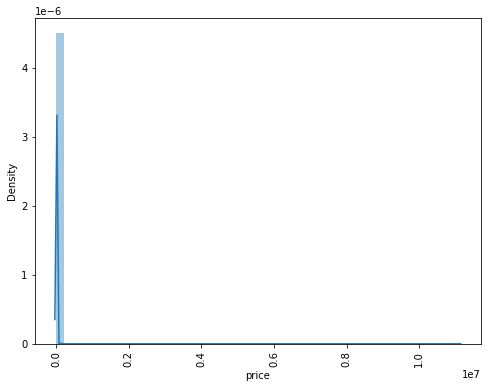

From this alone, we can see that there's outliers need to be removed. But first, let us separate the listing by listing type.

In [158]:
df['listing_type'].value_counts()

sale        39097
stud         7668
adoption     2016
Name: listing_type, dtype: int64

In [159]:
sale = df.loc[df['listing_type'] == 'sale']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


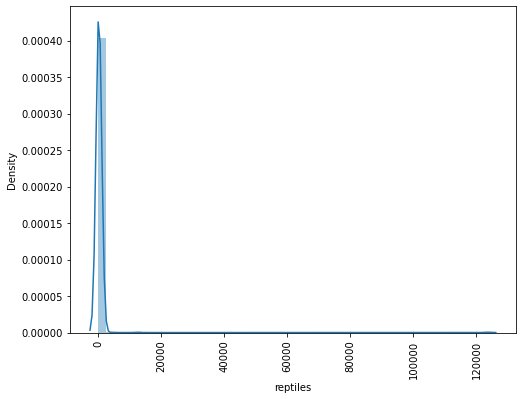

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


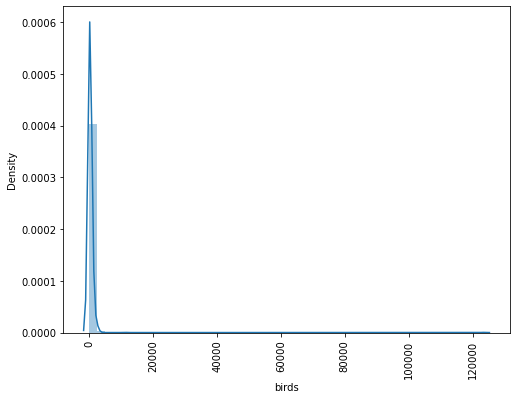

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


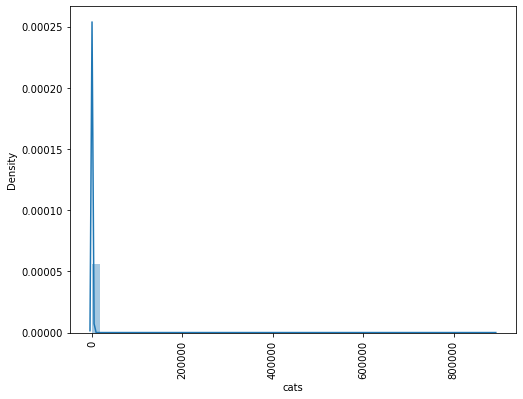

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


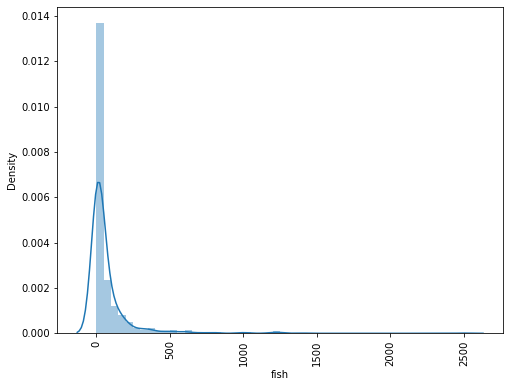

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


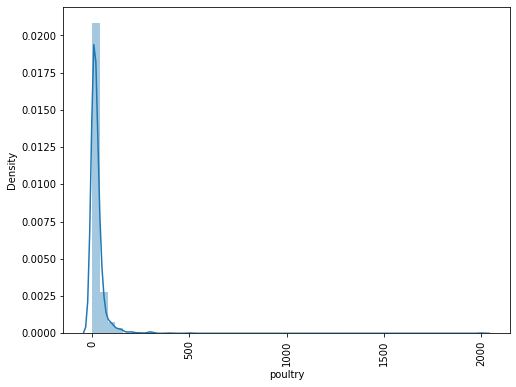

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


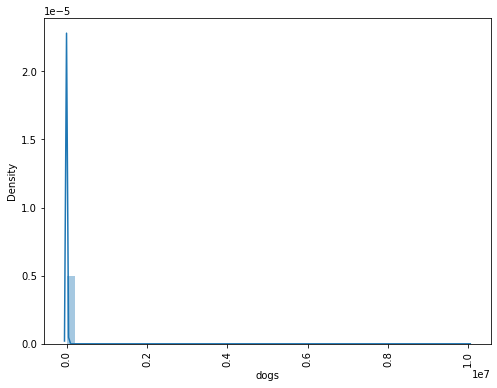

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


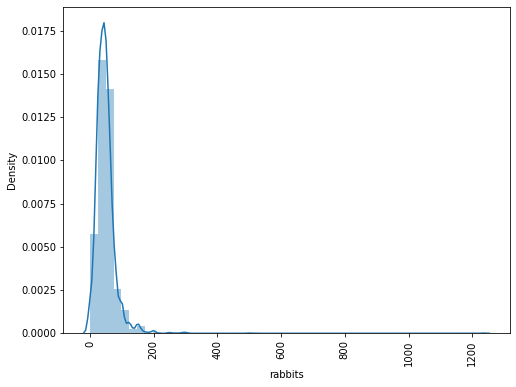

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


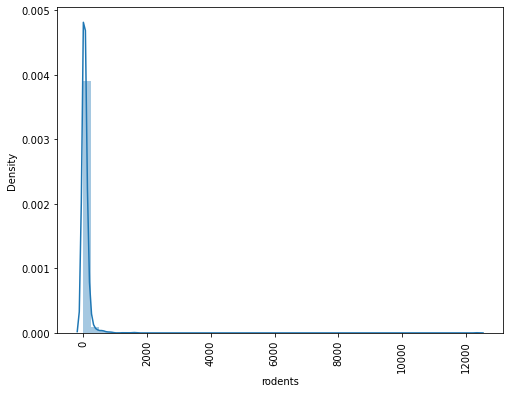

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


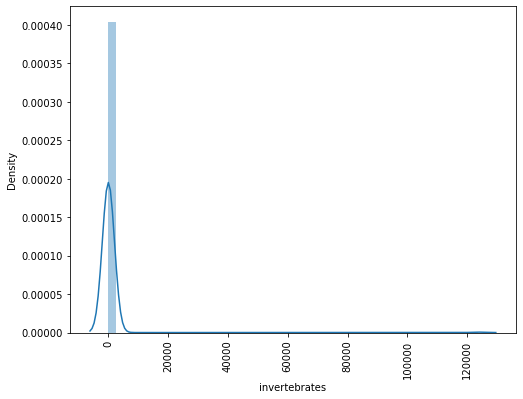

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


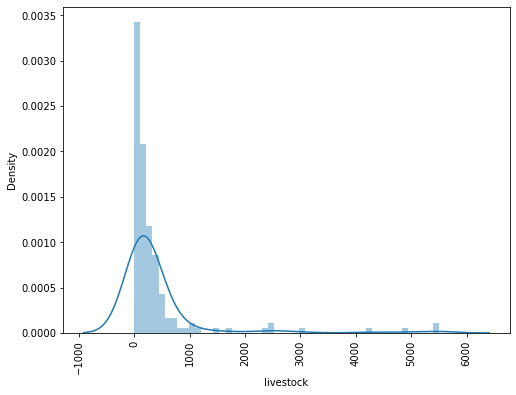

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


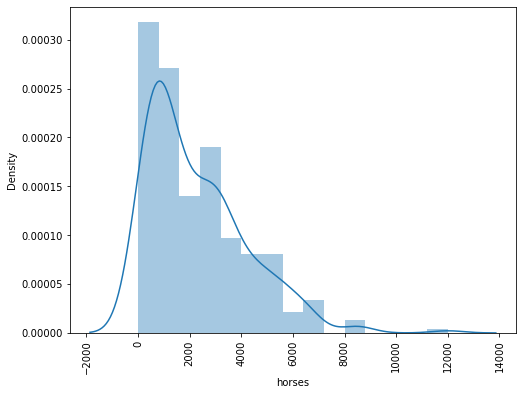

In [160]:
histogram (sale,'pet_type')

In [161]:
sale.describe()

,price
count,3.909700e+04
mean,1.495378e+03
std,7.571737e+04
min,0.000000e+00
25%,7.000000e+01
50%,5.000000e+02
75%,1.100000e+03
max,9.999999e+06


Let us take a look at 0.0 sale price

In [162]:
sale.loc[sale['price'] == 0 ]

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
32,African Cichlids bundle,0.0,Cichlids,1 year,unknown,"hi, I have got around 19 African cichlids look...",Margaret B,Peterculter,Breeder,sale,fish
33,Guppies for sale,0.0,Other/Mixed Breed,12 weeks,unknown,2 1/2 months old mixed guppies for sale: make...,Anil G.,Aberdeen,Individual,sale,fish
441,Full list baby ball python CB21,0.0,Python Snake,1 year,Mixed,"Passione breeder based in Southampton, here to...",Eden Garden Reptiles,Southampton,Breeder,sale,reptiles
521,"3 x Clawed frogs wild type,3 males I believe,",0.0,Other/Mixed Breed,2 weeks,unknown,Reducing the number that I have as the tank is...,Jacqueline s.,Bournemouth,Individual,sale,fish
561,Cockbirds pure bantams free to good homes,0.0,Chickens,8 months,Male,One silver marble colour one shiny black lovel...,Carli,Bournemouth,Breeder,sale,poultry
...,...,...,...,...,...,...,...,...,...,...,...
46726,chocolate seal point female mini lop,0.0,Mini Lop,1 year,Female,daisy ❤️ chocolate seal point pure bred mini l...,Hip Hop B,Leeds,Breeder,sale,rabbits
46846,BABY BLUE HOLICER RABBITS,0.0,Mixed Breed,6 months,Male,Iv had to put these babies under mixed breed a...,Mini F Stud,Leeds,Breeder,sale,rabbits
46885,RARE BABY HOLICER BABIES - READ DESCRIPTION,0.0,Continental Giant,14 weeks,Mixed,- I have put them into the continental giant c...,Mini F Stud,Leeds,Breeder,sale,rabbits
46888,Rabbits for sale,0.0,English Lop,15 weeks,Mixed,"We have 5 beautiful rabbits for sale,they are ...",Kian R.,Wakefield,Individual,sale,rabbits


It's less than 2% of our data, how about the outliers?

In [163]:
sale.sort_values(by=['price'], ascending=False).head(30)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
9625,2 male Chihuahua puppies for sale,9999999.0,Chihuahua,9 weeks,Male,Here we have two beautiful stunning chihuahua ...,Danielle E.,Kidderminster,Individual,sale,dogs
1530,Working Cocker spaniel dog pup,9999999.0,Cocker Spaniel,12 weeks,Male,One Liver Working cocker spaniel dog pup for s...,Joanne b.,Lymington,Licensed Breeder,sale,dogs
28646,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗 SIRE is KC - s...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
42999,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗 SIRE is KC - slo...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
17105,❌••L4 FLUFFY CARRIERS••❌Coco girl❌,987654.0,French Bulldog,14 weeks,Mixed,❤️Beautiful pups from our blue girl❤️ Romeo ...,JACQUELINE I.,Hailsham,Individual,sale,dogs
2821,Stolen coco,888888.0,Bengal,2 years,unknown,Good morning we haven't seen coco since 15th F...,Nic I.,Stonehouse,Individual,sale,cats
23757,ragdoll cross,150350.0,Ragdoll,10 weeks,Mixed,"5 stunning ragdoll cross kittens, 3 girls 2 bo...",Layna L.,Runcorn,Breeder,sale,cats
4943,LOVELY BLACK GIRL TICA REG NO SILLY OFFERS PLEASE,123654.0,Sphynx,1 year,unknown,Hi. We have for sale our beautiful girl that w...,Arkadiusz B.,Sandy,Individual,sale,cats
26635,XL BULLY girls and boys avalable,123456.0,American Bully,4 weeks,Mixed,here we have a 1 of litter of xl bullys full A...,Jake D.,Redditch,Individual,sale,dogs
38315,Various Tarantulas For Sale,123456.0,Tarantulas,1 year,Mixed,SLINGS 0.0.8 Caribena Veriscolor 1-2cm £20 0...,Lady Amherst’s Gundogs,Diss,Licensed Breeder,sale,invertebrates


From the histograms, we can infer that:
- although there isn't that many, we have pretty good data for horses
- other animals are littered with extreme outliers.
- it's likely better to separate the data by pet column before removing outliers.

The top priced entries makes no sense, some are not even real sale listing. They should be dropped.

In [164]:
sale['price'].value_counts()

1000.0    1987
1500.0    1673
50.0      1446
100.0     1377
1200.0    1159
          ... 
565.0        1
27.0         1
785.0        1
1245.0       1
1880.0       1
Name: price, Length: 379, dtype: int64

In [165]:
sale.loc[sale['pet_type'] == 'dogs' ].describe()

,price
count,1.567000e+04
mean,3.168297e+03
std,1.193322e+05
min,1.000000e+01
25%,8.500000e+02
50%,1.200000e+03
75%,1.700000e+03
max,9.999999e+06


In [166]:
sale.loc[sale['pet_type'] == 'dogs' ].sort_values(by=['price'], ascending=True).head(30)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
47578,Cane Corso puppy FREE to a good home! HOME CHECKS,10.0,Cane Corso,6 months,Male,Bear is our family pet however we have come to...,Aimee H.,Leeds,Individual,sale,dogs
28961,Rehoming some of my boys and girls,10.0,French Bulldog,2 years,Male,due to ill health i am rehoming my boys and gi...,Saif A.,Manchester,Individual,sale,dogs
6038,Belgian Malinois x lurcher,10.0,Belgian Shepherd Dog,3 years,unknown,"Not for Sale - Gorgeous boy, very playful, ful...",A S.,Cambridge,Individual,sale,dogs
15541,Gorgeous boy for stud,10.0,Mixed Breed,3 years,Male,Buster is a friendly 3 year old well behaved s...,Timber K.,Liskeard,Individual,sale,dogs
6174,Belgian Shephard x Mastiff,10.0,Belgian Shepherd Dog,1 year,unknown,EXPERIENCED DOG OWNERS ONLY. my dog diesel is ...,Alex T.,Rushden,Breeder,sale,dogs
44722,Last Male French Bulldog puppy,10.0,French Bulldog,7 weeks,Mixed,***Last Male pup*** We have for sale our beaut...,samantha j.,Northwich,Individual,sale,dogs
1596,Beautiful jack Russell puppy ALL SOLD,10.0,Jack Russell,3 months,Mixed,"All sold ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...",Jonathan W.,Salisbury,Individual,sale,dogs
6152,Dutch shepherd,10.0,German Shepherd,9 years,unknown,Shadow is free to a good home his a brilliant ...,Bradley O.,St Albans,Individual,sale,dogs
18782,Cocker spaniel and springer spaniel,10.0,English Springer Spaniel,6 weeks,Mixed,Our family pet dogs went missing on Thursday ...,Daniel A.,Ledbury,Individual,sale,dogs
26559,Small Yorkshire terrier puppies,10.0,Yorkshire Terrier,8 weeks,Mixed,Looking for forever homes for my beautiful yor...,Scarlett C.,Coventry,Individual,sale,dogs


In [167]:
sale.loc[(sale['pet_type'] == 'dogs') & (sale['Title'].str.contains('deposit')) ].sort_values(by=['price'], ascending=True)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
28936,Pomeranian Puppies for sale £200 deposit 2 secure,200.0,Pomeranian,8 weeks,Mixed,£200 deposit required to secure any of the pup...,Jessica J.,Saint Helens,Individual,sale,dogs
42445,No deposit!Mini Yorkshire Terrier 3 left,750.0,Yorkshire Terrier,9 weeks,Mixed,No deposit required! One beautiful girl and 2 ...,Alex,Newcastle,Breeder,sale,dogs
6313,Adorable Bichon Frise pups - place a deposit now!,1200.0,Bichon Frise,6 weeks,Mixed,"Our bichon, Willow, coming up to 3 years old i...",Claire S.,Luton,Individual,sale,dogs
28609,No deposit!Mini Yorkshire Terrier 3 left,1350.0,Yorkshire Terrier,9 weeks,Mixed,No deposit required! One beautiful girl and 2 ...,Alex,Newcastle,Breeder,sale,dogs
7784,Saint Bernard puppies viewing & deposits accep...,1700.0,Saint Bernard,3 weeks,Mixed,**update** beautiful purple has found her fore...,Sevin H.,Birmingham,Individual,sale,dogs
38165,Doberman ready deposit taken,1800.0,Mixed Breed,5 weeks,Mixed,Full pedigree doberman. 3 quater bred with ful...,Dany87,Lincoln,Breeder,sale,dogs


After looking more at the data, what I'm sure of:
- There are duplicates that scraper couldn't identify. This is likely because title and description changed during scraping.
- Some sellers put deposit as sale price, which explains why some listing looks extremely cheap
- Some cheap listing is because owner couldn't take care of the pet anymore and look for new family to take over
- Odd entries are because owner want to get in contact before deciding the sale
- Some listing are service offers which we are not interested in

Data that we need to remove:
- Duplicates
- Those that aren't actual sale price. The hard part is identifiying them.
- Listing that are not in English. Those are likely to cause problems with NLP model.
- Those that service (microchipping, dog walking, etc)

To remove duplicates, we could ignore description and title column. The other columns are less likely to change after reposting.

Identify those listing not in english with langdetect.

In [168]:
df = df[~df.duplicated(subset=['price', 'species', 'age', 'gender', 'seller_name', 'seller_location','seller_type',
                               'listing_type','pet_type'])].reset_index(drop=True)
df

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
0,unsexed green tree python + 60cm vivtek,1000.0,Python Snake,3 years,Mixed,~3years old gtp biak x sorong Typical gtp a...,Patryk M.,Aberdeen,Individual,sale,reptiles
1,Leopard gecko (f),80.0,Gecko,1 year,Female,Selling this leopard gecko I've had the joy of...,Dana I.,Aberdeen,Individual,sale,reptiles
2,rexy,100.0,Iguana,4 years,Male,rexy needs a new home ASP sadly I don't not ...,Gillian W.,Aberdeen,Individual,sale,reptiles
3,Panther Chameleon and full set up,550.0,Chameleon,9 months,Male,Blue is a 6 month old Nosey Mitsio chameleon. ...,Craig H.,Aberdeen,Individual,sale,reptiles
4,Hand reared white Indian ringnecks,300.0,Parakeets,9 weeks,Mixed,I have 2 stunning white Indian ringnecks. 1 ma...,Dave T.,Aberdeen,Individual,sale,birds
...,...,...,...,...,...,...,...,...,...,...,...
42184,canarys for sale all colour plus new colours,40.0,Canaries,7 weeks,Mixed,there are all mixed cocks and hens new volour ...,Robert n.,Knottingley,Breeder,sale,birds
42185,TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW,2150.0,Macaws,4 years,Male,Rainbow is a beautiful example of a blue and g...,The Bradford Birdman,Bradford,Licensed Breeder,sale,birds
42186,Hand reared indian ringnecks babys,350.0,Parrots,1 year,Male,Hand reared cuddly silly tame little babys for...,Waqar A.,Bradford,Breeder,sale,birds
42187,One yellow one orange canary.,60.0,Canaries,2 years,Mixed,I’m reluctantly listing my canaries (peach and...,Amylia R.,Barnsley,Individual,sale,birds


In [169]:
df['language'] = df['description'].apply(detect)

LangDetectException: No features in text.

In [ ]:
df

In [52]:
#dropping values
sale.drop(sale[sale['price'] > 5000].index, inplace=True)
sale.drop(sale[sale['price'] == 0.0].index, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
sale.sort_values(by=['price'], ascending=False).head(30)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
26673,Top quality breeding xl puppys,5000.0,American Bully,14 weeks,unknown,In house special breeding at Top dog bullys uk...,Michelle D.,Bilston,Individual,sale,dogs
37020,Don’t miss out 1smooth & 1rough choc carrier l...,5000.0,Chow Chow,8 weeks,Female,Here we had a special breeding with some very ...,JEREMIAH FITZROY H.,Weybridge,Individual,sale,dogs
36708,Rare Golden White Sable Tiny Female Chihuahua,5000.0,Chihuahua,9 weeks,Female,"Hello,\n\nI have for sale the most beautiful r...",Agatha L.,London,Individual,sale,dogs
7791,Beatiful puppy’s with top bloodlines,5000.0,English Bulldog,7 weeks,Mixed,Adorable litter of puppy’s \n-3 fully suited l...,Chloe H.,Wolverhampton,Individual,sale,dogs
9271,Top quality breeding xl puppys,5000.0,American Bully,15 weeks,unknown,In house special breeding at Top dog bullys uk...,Michelle D.,Bilston,Individual,sale,dogs
8938,FLUFFY FRENCH BULLDOGS TESTABLE CHOCOLATE,5000.0,French Bulldog,10 weeks,Mixed,Here is my lovely litter off top quality gorge...,Jess F.,Oldbury,Breeder,sale,dogs
15848,New shade French bulldog puppy REDUCED,5000.0,French Bulldog,4 months,Mixed,How is this little man still available!!! He i...,Cambullz,Bishop Auckland,Breeder,sale,dogs
7840,New Shade Isabella and Tan,5000.0,French Bulldog,9 weeks,Mixed,Our a short and compact Lilac and Tan girl ca...,Arabella S.,Birmingham,Individual,sale,dogs
9655,2 year old lilac & tan tri female English Bulldog,5000.0,English Bulldog,3 years,unknown,Amazing opportunity to take home our beautiful...,Jessica B.,Solihull,Breeder,sale,dogs
8956,English bulldogs,5000.0,English Bulldog,4 months,Male,How are these still here people must not see q...,john r.,Tipton,Breeder,sale,dogs


In [54]:
sale.describe()

,price
count,38549.000000
mean,715.087421
std,765.946836
min,1.000000
25%,70.000000
50%,500.000000
75%,1100.000000
max,5000.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


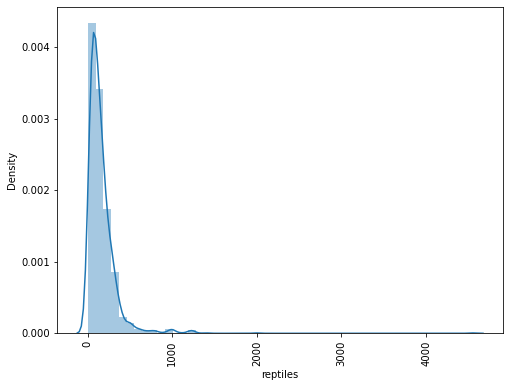

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


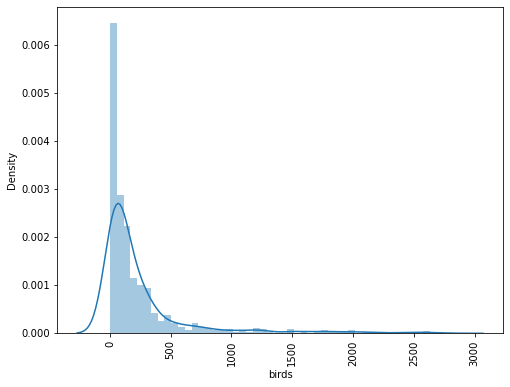

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


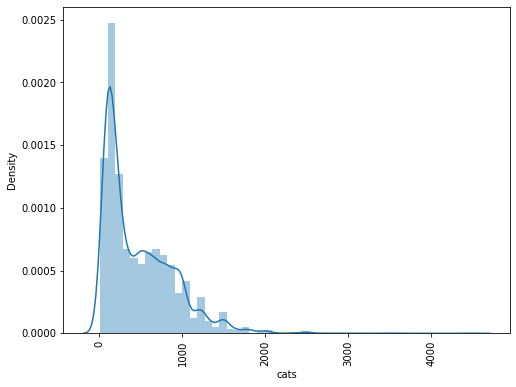

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


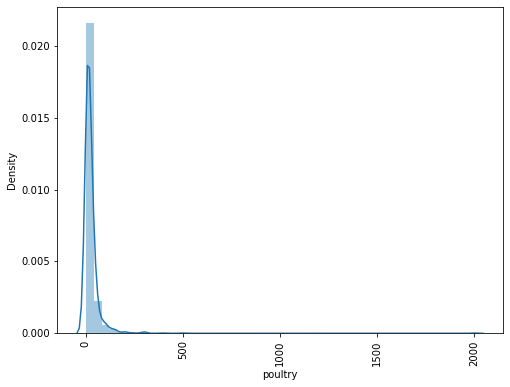

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


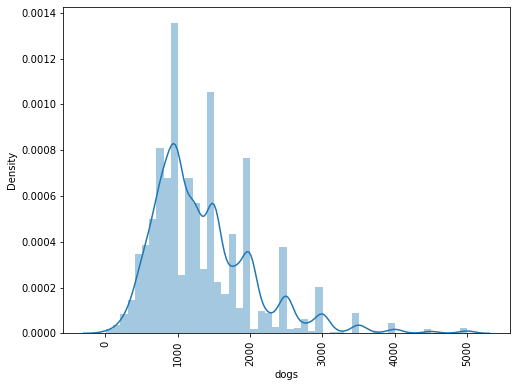

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


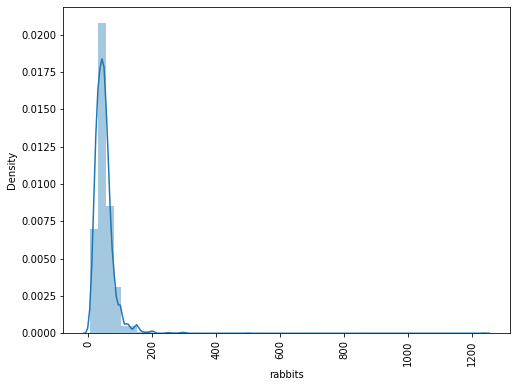

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


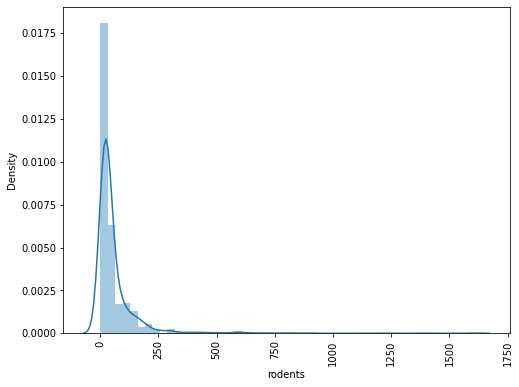

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


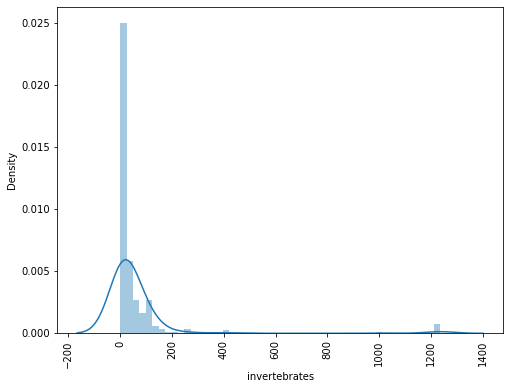

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


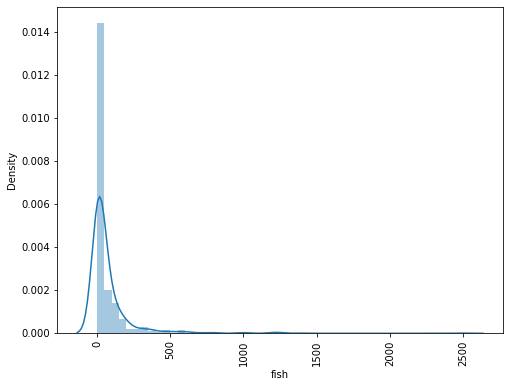

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


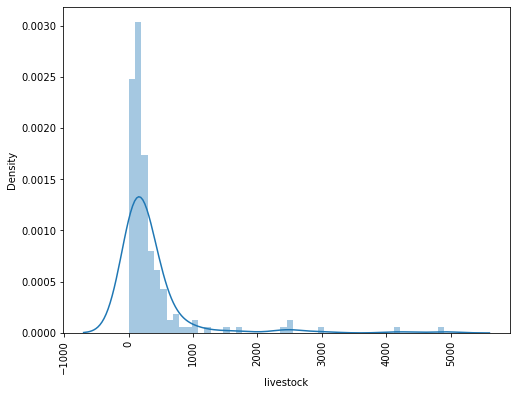

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


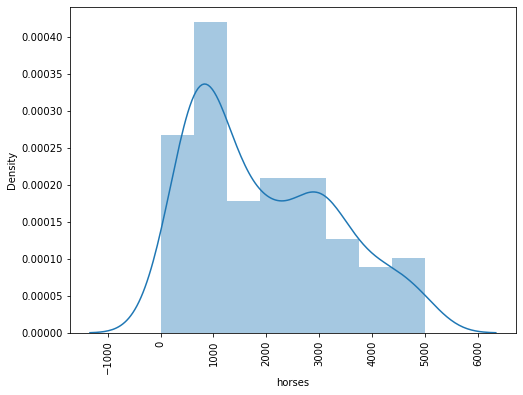

In [55]:
histogram (sale,'pet_type')